# Import Modules

## Standard Packages

In [1]:
import os
import sys
import os.path as path
import glob
import random
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
from datetime import date, datetime, timedelta, time
from timeit import default_timer as timer

/g/g92/jha3/VirtualEnv/py3_ml_wind/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


## User-Defined Functions

In [2]:
from helper_extract_wrf import generate_seed, init_random_generator
from helper_extract_wrf import get_data_file_names, downsample_data_files
from helper_extract_wrf import get_history_file_indices, get_datetime_for_data_files
from helper_extract_wrf import create_df_sampled_time, plot_sampled_datetime
from helper_extract_wrf import get_grid_indices_all, read_single_data_file
from helper_extract_wrf import plot_contours_at_timestamp, plot_pdf_at_timestamp

# Global Start Time

In [3]:
global_start_time = timer()

# Variables to be used for extracting WRF data

In [4]:
# WRF data set location and the extracted data set location
data_files_location = '/p/vast1/climres/DFM_reanalysis'
extracted_data_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted'

# The current data set params
data_set_count = 0
percent_files_to_use = 0.010863484  # f1 = what percent of available files to use
#percent_files_to_use = 100.00  # f1 = what percent of available files to use
percent_grid_points_to_use = 0.005  # f2 = what percent of grid points to use
max_history_to_consider = 20 # n_history in hours
history_interval        = 4

# Generate seed for the random number generator

In [5]:
seed = generate_seed()
random_state = init_random_generator(seed)

# File Names

In [6]:
module_start_time = timer()
data_files_list = get_data_file_names(data_files_location)
module_end_time = timer()
print('Module "get_data_file_names" computing time: {} s'.format(module_end_time - module_start_time))


Getting the names of the data files at the dir : 
 /p/vast1/climres/DFM_reanalysis 

years_list: ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'] 

Getting the names of the data files for the year : 2000
... Found 8784 files for this year
Getting the names of the data files for the year : 2001
... Found 8760 files for this year
Getting the names of the data files for the year : 2002
... Found 8760 files for this year
Getting the names of the data files for the year : 2003
... Found 8760 files for this year
Getting the names of the data files for the year : 2004
... Found 8784 files for this year
Getting the names of the data files for the year : 2005
... Found 8760 files for this year
Getting the names of the data files for the year : 2006
... Found 8760 files for this year
Getting the names of the data files for the year : 2007
... Found 8760 files for this year
Get

# Downsample Files

In [7]:
module_start_time = timer()
sampled_file_indices, sampled_data_files = downsample_data_files (data_files_list, percent_files_to_use, max_history_to_consider, random_state)
module_end_time = timer()
print('Module "downsample_data_files" computing time: {} s'.format(module_end_time - module_start_time))


Randomly selecting approx 0.010863484 % of the data files
Selected 20 data files out of 184103 total and 184083 usable considering historical data
Module "downsample_data_files" computing time: 0.07478836504742503 s


# Get History File Indices

In [8]:
module_start_time = timer()
history_file_indices = get_history_file_indices (sampled_file_indices, max_history_to_consider, history_interval)
module_end_time = timer()
print('Module "get_history_file_indices" computing time: {} s'.format(module_end_time - module_start_time))


Determining history file indices corresponding to sampled file/time indices...
Module "get_history_file_indices" computing time: 0.000847421120852232 s


# Create timestamps and datetime of downsampled data files

In [9]:
module_start_time = timer()
sampled_time_stamps, sampled_datetime = get_datetime_for_data_files (sampled_data_files)
module_end_time = timer()
print('Module "get_datetime_for_data_files" computing time: {} s'.format(module_end_time - module_start_time))


Getting time stamps and datetime of the downsampled data files...
Module "get_datetime_for_data_files" computing time: 0.00040168967097997665 s


# Create DataFrame using sampled file indices, filenames, timestamps, and datetime

In [10]:
module_start_time = timer()
df_sampled_time = create_df_sampled_time (sampled_file_indices, sampled_data_files, sampled_time_stamps, sampled_datetime, history_file_indices)
module_end_time = timer()
print('Module "create_df_sampled_time" computing time: {} s'.format(module_end_time - module_start_time))


Creating DataFrame using sampled file indices, filenames, timestamps, and datetime...
Module "create_df_sampled_time" computing time: 0.0061491248197853565 s


In [11]:
#df_sampled_time[df_sampled_time['ref_time_indices'] < max_history_to_consider+10]

In [12]:
df_sampled_time.head(20)

,ref_time_indices,sampled_data_files,sampled_time_stamps,sampled_datetime,history_time_indices
0,91650,wrf_2010-06-15_19.nc,2010-06-15_19,2010-06-15 19:00:00,"[91630, 91634, 91638, 91642, 91646]"
1,122427,wrf_2013-12-19_04.nc,2013-12-19_04,2013-12-19 04:00:00,"[122407, 122411, 122415, 122419, 122423]"
2,26097,wrf_2002-12-23_09.nc,2002-12-23_09,2002-12-23 09:00:00,"[26077, 26081, 26085, 26089, 26093]"
3,82805,wrf_2009-06-12_05.nc,2009-06-12_05,2009-06-12 05:00:00,"[82785, 82789, 82793, 82797, 82801]"
4,104425,wrf_2011-11-30_02.nc,2011-11-30_02,2011-11-30 02:00:00,"[104405, 104409, 104413, 104417, 104421]"
5,106875,wrf_2012-03-11_04.nc,2012-03-11_04,2012-03-11 04:00:00,"[106855, 106859, 106863, 106867, 106871]"
6,36912,wrf_2004-03-18_00.nc,2004-03-18_00,2004-03-18 00:00:00,"[36892, 36896, 36900, 36904, 36908]"
7,132736,wrf_2015-02-21_17.nc,2015-02-21_17,2015-02-21 17:00:00,"[132716, 132720, 132724, 132728, 132732]"
8,35280,wrf_2004-01-10_00.nc,2004-01-10_00,2004-01-10 00:00:00,"[35260, 35264, 35268, 35272, 35276]"
9,20489,wrf_2002-05-03_17.nc,2002-05-03_17,2002-05-03 17:00:00,"[20469, 20473, 20477, 20481, 20485]"


# Plot Sampled Datetime


Plotting sampled datetime from the available data...


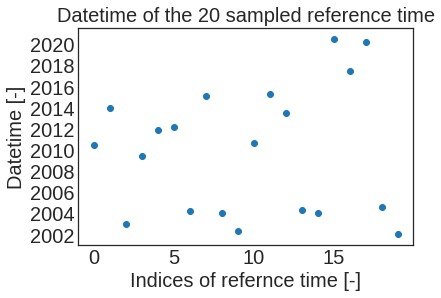

Module "plot_sampled_datetime" computing time: 0.30188382789492607 s


In [13]:
module_start_time = timer()
plot_sampled_datetime (df_sampled_time, extracted_data_loc)
module_end_time = timer()
print('Module "plot_sampled_datetime" computing time: {} s'.format(module_end_time - module_start_time))

# Get All the Grid Indices

In [14]:
module_start_time = timer()
data_file_to_read, grid_indices, grid_indices_flattened = get_grid_indices_all (data_files_location, sampled_file_indices, sampled_data_files)
module_end_time = timer()
print('Module "get_grid_indices_all" computing time: {} s'.format(module_end_time - module_start_time))


Getting all the grid indices from a randomly selcted file...
The selected file is: wrf_2013-12-19_04.nc
Module "get_grid_indices_all" computing time: 0.19046574085950851 s


# Read and Plot Quantities in a Randomly Selected Data File

## Read the Data in a Randonly Selected File

In [15]:
module_start_time = timer()
random_ind_of_downsampled_files = random.choice(range(len(sampled_file_indices)))
file_ind_to_read = sampled_file_indices[random_ind_of_downsampled_files]
data_file_to_read = sampled_data_files[random_ind_of_downsampled_files]
timestamp_to_read = sampled_time_stamps[random_ind_of_downsampled_files]
data_at_timestamp = read_single_data_file (data_files_location, data_file_to_read, timestamp_to_read)
module_end_time = timer()
print('Module "read_single_data_file" computing time: {} s'.format(module_end_time - module_start_time))


Reading data contained in the randomly selcted file: wrf_2002-01-25_23.nc...
Module "read_single_data_file" computing time: 0.12417954206466675 s


## Plot the Contours of QoIs for the Data Just Read Above

In [16]:
qoi_to_plot = ['HGT', 'Q2', 'U10', 'V10', 'FMC_1hr', 'FMC_10hr', 'FMC_100hr', 'T2', 'RH', 'PRECIP', 'PSFC', 'SWDOWN']

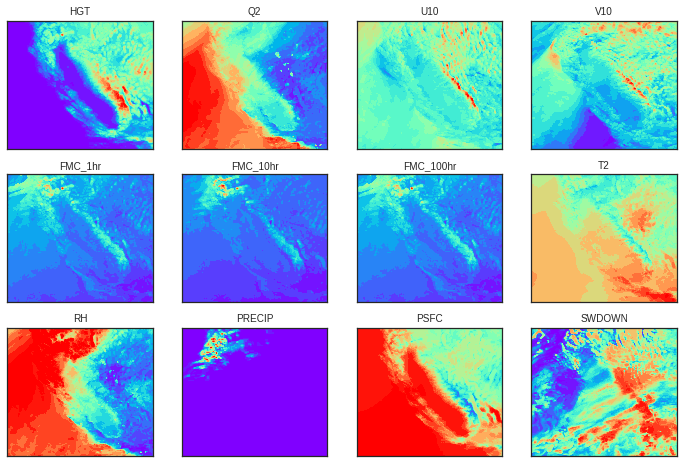

Module "plot_contours_at_timestamp" computing time: 3.937256787903607 s


In [17]:
module_start_time = timer()
plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc)
module_end_time = timer()
print('Module "plot_contours_at_timestamp" computing time: {} s'.format(module_end_time - module_start_time))

## Plot the PDF of QoIs for the Data Just Read Above

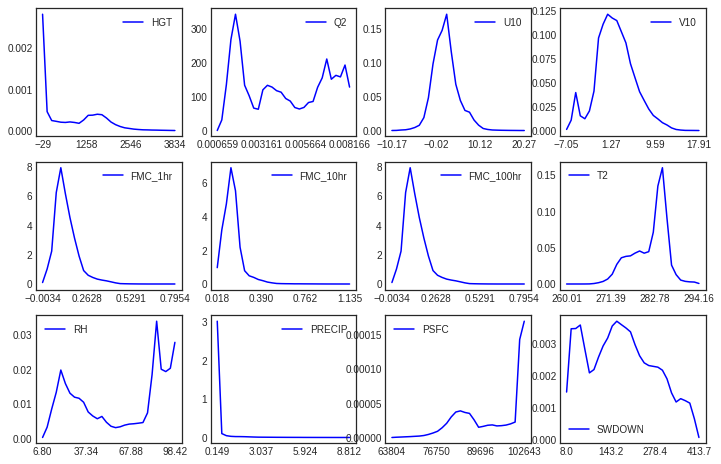

Module "plot_pdf_at_timestamp" computing time: 1.556904416065663 s


In [18]:
module_start_time = timer()
plot_pdf_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc)
module_end_time = timer()
print('Module "plot_pdf_at_timestamp" computing time: {} s'.format(module_end_time - module_start_time))

# Extract Considerable Indices

In [19]:
#grid_indices_valid = np.zeros((ny, nx), bool)

# Global End Time

In [20]:
global_end_time = timer()
print('Total computing time: {} s'.format(global_end_time - global_start_time))

Total computing time: 6.755051196087152 s


# Cells below this are old/legacy stuff for reference

# Grid Dimensions, Downsample Grid Points

In [ ]:
df_for_all_files = pd.DataFrame()
for file_count, data_file_name in enumerate(sampled_data_files):
    print ('\nReading data from file # {}, with name :- {}'.format(file_count, data_file_name))
    print('-----------------------------------------------------------------------')
    dfm_file_data = xr.open_dataset(path.join(data_files_location, data_file_name))
    
    df_for_single_file = downsample_grid_indices (data_file_name,dfm_file_data, percent_grid_points_to_use, 
                                                  max_history_to_consider, history_interval, frames_in_file)
    
    df_for_all_files = df_for_all_files.append(df_for_single_file).reset_index(drop = True)

In [ ]:
#df_for_all_files.head(10)

# Save the extracted data

In [ ]:
data_set_name = 'extracted_data_%02d'%(data_set_count)
extracted_data_file_name = '{}.pkl'.format(data_set_name)
'''
extracted_data_file_name = '{}_files_{}pc_grid_points_{}pc_max_history_{}_hist_interval_{}.pkl'.format(
                            data_set_name, # name of data set
                            percent_files_to_use, # f1 = what percent of available files to use
                            percent_grid_points_to_use, # f2 = what percent of grid points to use
                            max_history_to_consider, # n_history in hours
                            history_interval)
'''
extracted_data = {'percent_files_to_use': [percent_files_to_use],
                 'percent_grid_points_to_use': [percent_grid_points_to_use],
                 'max_history_to_consider': [max_history_to_consider],
                 'history_interval': [history_interval],
                 'number_of_files_used' : [len(sampled_data_files)],
                 'number_of_data_points' : [len(df_for_all_files)],
                 'df_for_all_files': df_for_all_files}
extracted_data_file_handle = open(os.path.join(
    extracted_data_loc, extracted_data_file_name), 'wb')
pickle.dump(extracted_data, extracted_data_file_handle)
extracted_data_file_handle.close()

In [ ]:
del extracted_data['df_for_all_files']
#extracted_data['index'] = 0

In [ ]:
tab_data_file_name = '{}.csv'.format(os.path.join(extracted_data_loc, data_set_name))
tabulated_data = pd.DataFrame.from_dict(extracted_data).reset_index(drop = True)
tabulated_data.to_csv(tab_data_file_name, index = False)

In [ ]:
#tabulated_data

# Load extracted data from pickle file

In [ ]:
loaded_data = pickle.load(open(os.path.join(
    extracted_data_loc, extracted_data_file_name), 'rb'))

In [ ]:
#loaded_data['df_for_all_files'][5:15]